## Visualisation of NEMO/GEM/Observations using XArray
This notebook demonstrates the use of several tools for easy loading and visualization of model results and drifter observations. Most of these tools require `xarray`, and rather than make them flexible to other packages, I thought I would just demonstrate their use with `xarray` here.

First we'll import the necessary libraries and set our preferred notebook formatting.

In [ ]:
from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools
from collections     import OrderedDict
from matplotlib      import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
rcParams.update({'font.size': 12})
rcParams["axes.formatter.useoffset"] = False

Using the loading tools requires only a timerange argument. There are several additional keyword arguments should you need them.

In [4]:
timerange = ['2016 Jul 1 00:00', '2016 Jul 2 00:00']

### Loading atmospheric forcing data from ERDDAP
GEM2.5 HRDPS atmospheric forcing variables are downloaded from the ERDDAP server and compiled into an `xarray` dataset. Additional variables can be requested using keyword arguments.

In [5]:
GEM  = nc_tools.load_GEM_from_erddap( timerange)
print(GEM)

<xarray.Dataset>
Dimensions:    (gridX: 256, gridY: 266, time: 25)
Coordinates:
  * gridY      (gridY) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * gridX      (gridX) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * time       (time) datetime64[ns] 2016-07-01 2016-07-01T01:00:00 ...
Data variables:
    latitude   (gridY, gridX) float32 ...
    longitude  (gridY, gridX) float32 -126.984 -126.956 -126.927 -126.898 ...
    u_wind     (time, gridY, gridX) float64 ...
    v_wind     (time, gridY, gridX) float64 ...


### Loading model results from ERDDAP
Likewise, NEMO results are downloaded from ERDDAP and compiled into an `xarray` dataset, and keyword arguments can be used to request additional variables, or fewer variables to save loading time and memory.

**NOTE** All variables are indexed on the T grid, so the velocities should be unstaggered before use. I didn't want to have to carry around 4 different grids.

In [6]:
NEMO = nc_tools.load_NEMO_from_erddap(timerange)
print(NEMO)

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 24)
Coordinates:
  * gridY        (gridY) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time         (time) datetime64[ns] 2016-07-01T00:30:00 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
Data variables:
    bathymetry   (gridY, gridX) float32 ...
    latitude     (gridY, gridX) float32 ...
    longitude    (gridY, gridX) float32 ...
    u_vel        (time, depth, gridY, gridX) float64 ...
    v_vel        (time, depth, gridY, gridX) float64 ...
    w_vel        (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salinity     (time, depth, gridY, gridX) float64 ...
    temperature  (time, depth, gridY, gridX) float64 ...
    mask         (depth, gridY, gridX) int8 ...


### Loading data from the local filespace
You can also load GEM or NEMO results directly from our filespace. This function uses a Python version of NCO.ncrcat to concatenate the NetCDF files, which is super slooooow. I think it would useful to be able to do this going forward, maybe there is a faster way? (The example has fewer variables and depths to speed things up)

In [19]:
nc_tools.load_NEMO_from_path(timerange, fields=['salinity'], depth=[0, 1])

<xarray.Dataset>
Dimensions:     (depth: 1, gridX: 398, gridY: 898, time: 24)
Coordinates:
  * gridX       (gridX) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * gridY       (gridY) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * depth       (depth) float32 0.5
  * time        (time) datetime64[ns] 2016-07-01T00:30:00 ...
Data variables:
    bathymetry  (gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    latitude    (gridY, gridX) float64 46.86 46.86 46.86 46.87 46.87 46.87 ...
    longitude   (gridY, gridX) float64 -123.4 -123.4 -123.4 -123.4 -123.4 ...
    salinity    (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...

### Loading drifter data
Romain has all of the drifter results archived as geojson files in his directory on /ocean. They can be loaded using `data_tools.load_drifters`.

In [8]:
DRIFTERS = data_tools.load_drifters()

`DRIFTERS` is a nested dictionary of `xarray` datasets, grouped at the top layer by deployment.

In [10]:
print(DRIFTERS.keys())

odict_keys(['deployment1', 'deployment2', 'deployment3', 'deployment4', 'deployment5', 'deployment6', 'deployment7', 'deployment8'])

The next layer is drifter ID.

In [12]:
print(DRIFTERS['deployment7'].keys())

odict_keys(['Drifter74', 'Drifter75', 'Drifter76', 'Drifter71', 'Drifter72', 'Drifter73'])

Each drifter is an `xarray` dataset.

In [20]:
print(DRIFTERS['deployment7']['Drifter76'])

<xarray.Dataset>
Dimensions:  (time: 1584)
Coordinates:
  * time     (time) datetime64[ns] 2016-06-28T14:21:35 2016-06-28T14:31:07 ...
Data variables:
    lon      (time) float64 -123.2 -123.2 -123.2 -123.2 -123.2 -123.2 -123.2 ...
    lat      (time) float64 49.03 49.03 49.03 49.03 49.03 49.03 49.02 49.02 ...


### Data processing
Unstaggering of velocities to the T grid is done explicitly with respect to dimension (e.g., zonal velocity is shifted in the x-direction). Unstaggering also preserves the `xarray` structure. Lazy loading cannot survive this step, so this process can be time-consuming for large ERDDAP requests.

In [ ]:
NEMO['u_vel'] = viz_tools.unstagger_xarray(NEMO.u_vel, 'gridX')
NEMO['v_vel'] = viz_tools.unstagger_xarray(NEMO.v_vel, 'gridY')
NEMO['w_vel'] = viz_tools.unstagger_xarray(NEMO.w_vel, 'depth')

## Visualisation
There are two main functions that handle model visualisation: `visualisations.plot_tracers`, and `visualisations.plot_velocities`. For simplicity, both accept `xarray` Datasets as inputs, and the field names are assumed to be consistent with the conventions shown above for loading data. Changing `xarray` field names on the fly and merging DataArrays is fairly straight-forward and can be found in the `xarray` documentation. These functions should be well-suited for most simple model visualisation applications, perhaps with a little modification.

### Tracers
The tracer plotting routine `visualisations.plot_tracers` accepts any 2-D slice of the NEMO or GEM Dataset and plots the orientation accordingly. Here we have a plan view of surface salinity.

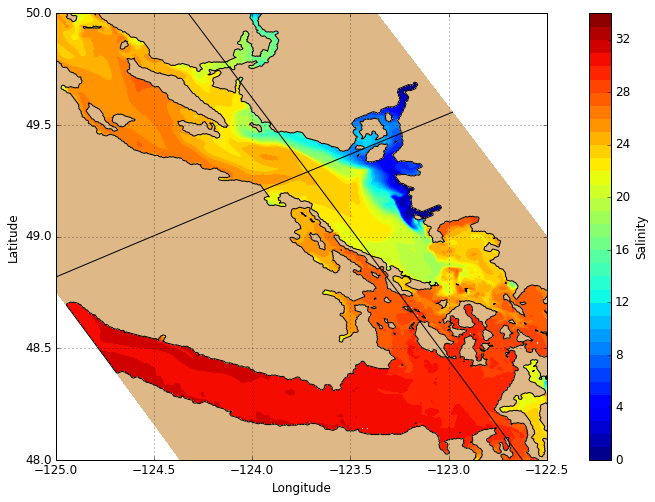

In [119]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
# Coastline
viz_tools.plot_land_mask(ax, NEMO, coords='map', color='burlywood', server='ERDDAP')
viz_tools.plot_coastline(ax, NEMO, coords='map', server='ERDDAP')

# Plot surface salinity
C_NEMO = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, depth=0))
fig.colorbar(C_NEMO, label='Salinity')

# Plot sections
ax.plot(NEMO.longitude.isel(gridY=493), NEMO.latitude.isel(gridY=493), 'k-')
ax.plot(NEMO.longitude.isel(gridX=255), NEMO.latitude.isel(gridX=255), 'k-')

# Prettying
viz_tools.set_aspect(ax)
ax.set_xlim([-125, -122.5])
ax.set_ylim([48, 50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()

With a different 2-D slice we obtain a cross-section along the section track shown above. There is a function `viz_tools.plot_boundary` that plots the landmask using the 3-D mesh mask. The white space appears because the mesh mask is based on the new bathymetry but the results being plotted are not. This will be fixed down the road.

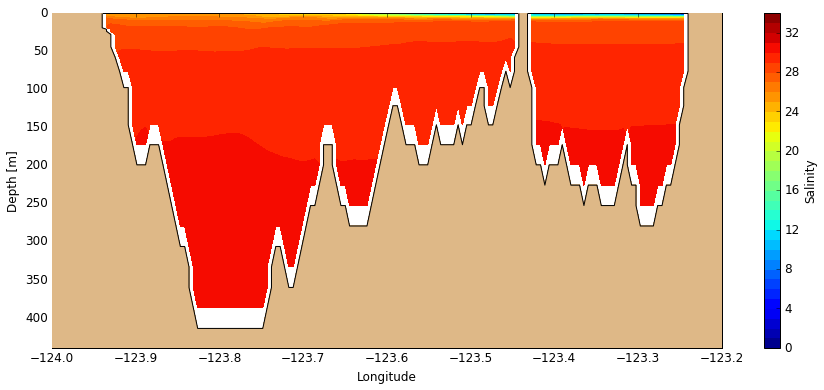

In [120]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    
# Landmask
viz_tools.plot_boundary(ax, NEMO.isel(time=0, gridY=493))

# Plot salinity cross-section
C_NEMO = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, gridY=493))
fig.colorbar(C_NEMO, label='Salinity')

# Prettying
ax.set_xlim([-124, -123.2])
ax.set_ylim([440, 0])
ax.set_xlabel('Longitude')
ax.set_ylabel('Depth [m]')

plt.show()

And with another 2-D slice we obtain an along-strait section (track shown above on map).

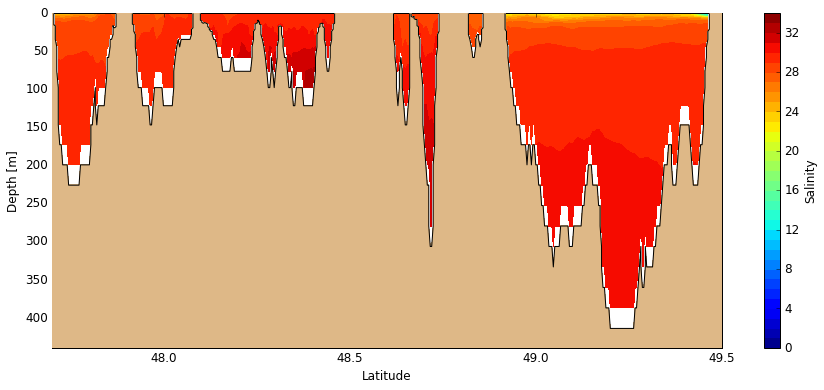

In [121]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    
# Landmask
viz_tools.plot_boundary(ax, NEMO.isel(time=0, gridX=255))

# Plot salinity along-sections
C_NEMO = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, gridX=255))
fig.colorbar(C_NEMO, label='Salinity')

# Prettying
ax.set_xlim([47.7, 49.5])
ax.set_ylim([440, 0])
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth [m]')

plt.show()

### Velocities
Velocites are plotted using `visualisations.plot_velocities` which works similarly to `plot_tracers` except only horizontal velocity slices are accepted.

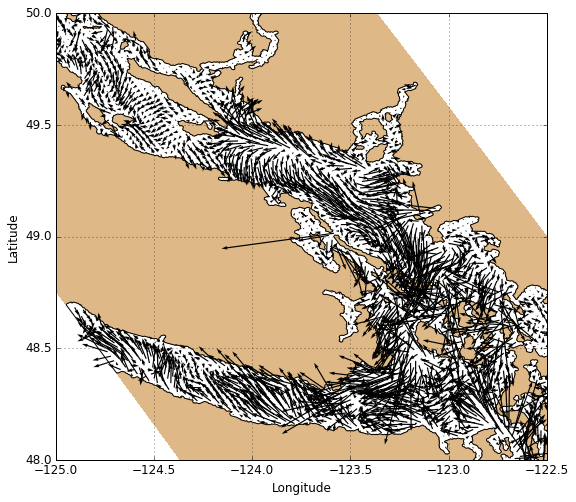

In [19]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Coastline
viz_tools.plot_land_mask(ax, NEMO, coords='map', color='burlywood', server='ERDDAP')
viz_tools.plot_coastline(ax, NEMO, coords='map', server='ERDDAP')

# Plot surface currents
Q_NEMO = visualisations.plot_velocity(ax, 'NEMO', NEMO.isel(time=0, depth=0))

# Prettying
viz_tools.set_aspect(ax)
ax.set_xlim([-125, -122.5])
ax.set_ylim([48, 50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()

GEM2.5 HRDPS winds can be plotted using the same function, with a few keyword arguments.

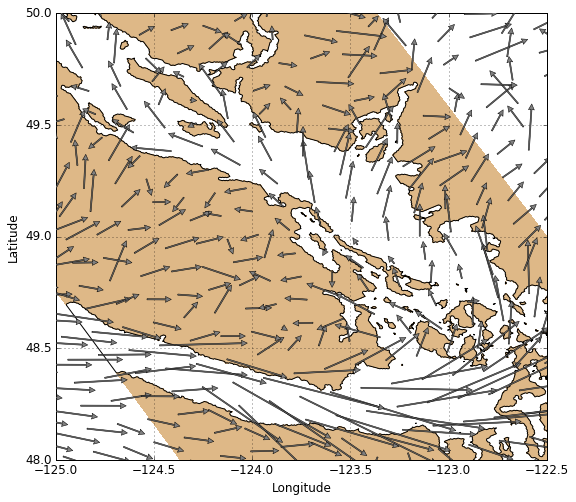

In [21]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Coastline
viz_tools.plot_land_mask(ax, NEMO, coords='map', color='burlywood', server='ERDDAP')
viz_tools.plot_coastline(ax, NEMO, coords='map', server='ERDDAP')

# Plot surface currents
Q_GEM = visualisations.plot_velocity(ax, 'GEM', GEM.isel(time=0),
                                     color='gray', scale=40, linewidth=0.5, headwidth=5, mask=False)

# Prettying
viz_tools.set_aspect(ax)
ax.set_xlim([-125, -122.5])
ax.set_ylim([48, 50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()

### Drifters
Drifters can be plotted using the function `visualisations.plot_drifters`. This function plots them one at a time, taking a given drifter's `xarray` Dataset as input. Use a loop to plot all drifters from a given deployment, and use an index for color control. To plot the drifter track up until a given point, slice the `xarray` Dataset from the beginning of the time record up until that time.

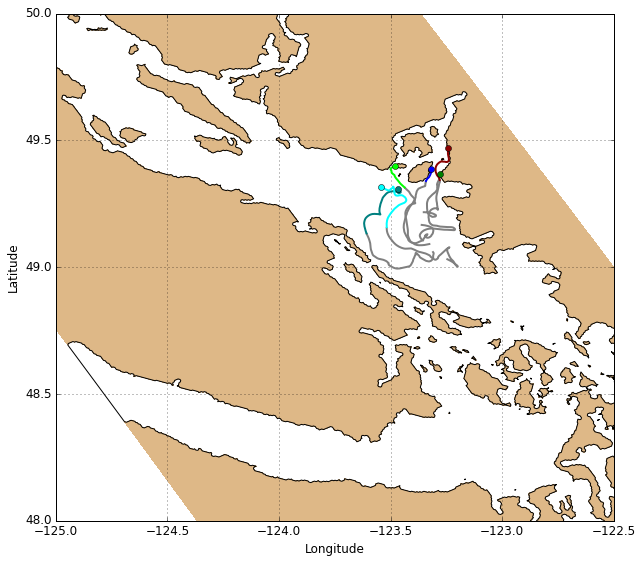

In [62]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Drifter track object storage dict
DRIFT_OBJS = OrderedDict()

# Define color palette for individual tracks
palette = ['blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
           'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown']
    
# Coastline
viz_tools.plot_land_mask(ax, NEMO, coords='map', color='burlywood', server='ERDDAP')
viz_tools.plot_coastline(ax, NEMO, coords='map', server='ERDDAP')

# Plot drifter tracks (one at a time)
for index, drifter in enumerate(DRIFTERS['deployment7'].items()):
    DRIFT_OBJS[drifter[0]] = visualisations.plot_drifters(
        ax, drifter[1].sel(time=slice(None, timerange[0])), color=palette[index])

# Prettying
viz_tools.set_aspect(ax)
ax.set_xlim([-125, -122.5])
ax.set_ylim([48, 50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()